# Gaussian on a Grid Test with compositional score matching

In this notebook, we will test the compositional score matching on a hierarchical problem defined on a grid.
- The observations are on grid with `n_grid` x `n_grid` points.
- The global parameters are the same for all grid points with hyper-priors:
$$ \mu \sim \mathcal{N}(0, 3^2),\qquad \log\tau \sim \mathcal{N}(0, 1^2)$$

- The local parameters are different for each grid point
$$ \theta_{i,j} \sim \mathcal{N}(\mu, \tau^2)$$

-  In each grid point, we have a Brownian motion with drift:
$$ dx_t = \theta \cdot dt + \sqrt{dt} \cdot dW_t$$
- We observe $T=10$ time points for each grid point over a time horizon of `max_time=1`.

In [1]:
import os
import numpy as np

os.environ['KERAS_BACKEND'] = 'torch'
from bayesflow import diagnostics

from problems.gaussian_grid import Prior, Simulator, visualize_simulation_output, plot_shrinkage, get_stan_posterior

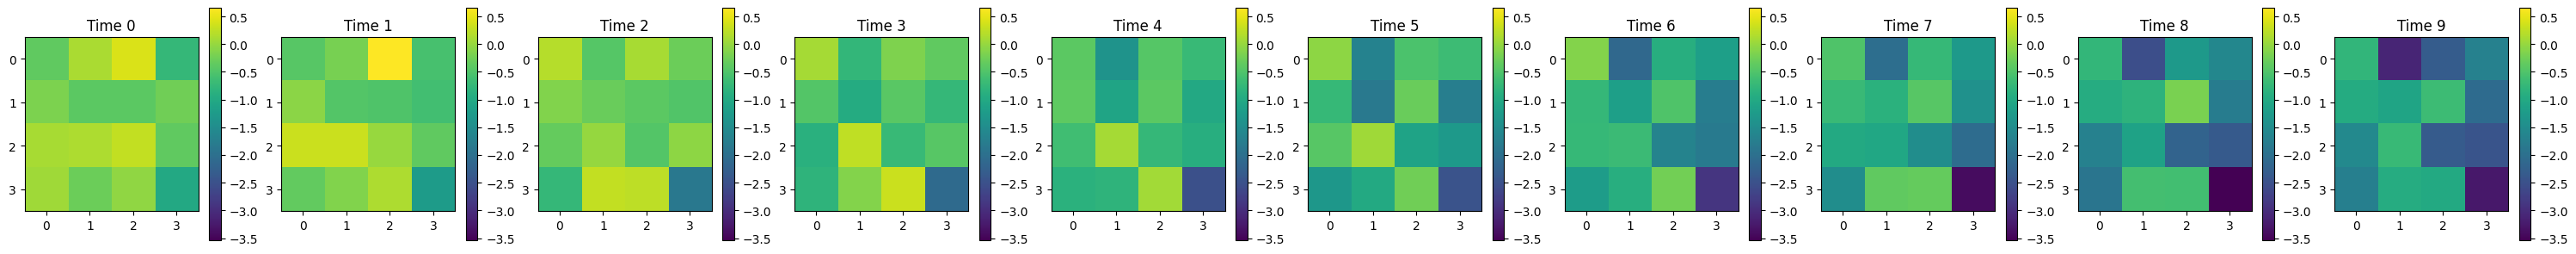

In [3]:
n_grid = 4
T = 10
N = n_grid * n_grid  # number of samples
data_samples = 1

prior = Prior(n_time_points=T)
simulator = Simulator(n_time_points=T)

global_param_names = [r'$\mu$', r'$\log \tau$']
local_param_names = [f'theta[{i}]' for i in range(n_grid * n_grid)]

# test the simulator
sim_test = simulator(prior.sample_full(1, n_grid=n_grid))['observable']
visualize_simulation_output(sim_test)

In [4]:
np.random.seed(0)

global_posteriors = []
local_posteriors = []

true_global = []
true_local = []

for i in range(data_samples):
    param_sample = prior.sample_full(1, n_grid=n_grid)
    true_global.append([param_sample['mu'][0, 0], param_sample['log_tau'][0, 0]])
    true_local.append(param_sample['theta'].flatten())
    sim_test = simulator(param_sample)['observable'][0]

    global_posterior, local_posterior = get_stan_posterior(sim_test, dt_obs=simulator.dt, verbose=False if i != 0 else True)
    global_posteriors.append(global_posterior)
    local_posteriors.append(local_posterior)

# make numpy arrays
global_posterior = np.stack(global_posteriors, axis=0)
local_posterior = np.stack(local_posteriors, axis=0).transpose(0, 2, 1)

true_global = np.stack(true_global, axis=0)
true_local = np.stack(true_local, axis=0)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a97a23f61390664adf7aa41cbc9f0891 NOW.
In file included from /var/folders/6l/dj45z5dn7zn0djmp1vjb65bh0000gn/T/pystan_yslnulo8/stanfit4anon_model_a97a23f61390664adf7aa41cbc9f0891_3172302687274500172.cpp:1315:
In file included from /Users/jonas.arruda/miniconda/envs/hierarchical-score-matching/lib/python3.11/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/jonas.arruda/miniconda/envs/hierarchical-score-matching/lib/python3.11/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/jonas.arruda/miniconda/envs/hierarchical-score-matching/lib/python3.11/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929:
/Users/jonas.arruda/miniconda/envs/hierarchical-score-matching/lib/python3.11/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSIO


Gradient evaluation took 3.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0.276688 seconds (Warm-up)
               0.222619 seconds (Sampling)
               0.499307 seconds (Total)


Gradient evaluation took 1.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
I

# Plotting

In [ ]:
diagnostics.recovery(global_posterior, true_global, variable_names=global_param_names)
diagnostics.calibration_ecdf(global_posterior, true_global, difference=True, variable_names=global_param_names);

In [ ]:
diagnostics.recovery(local_posterior, true_local, variable_names=local_param_names);

In [ ]:
plot_shrinkage(global_posterior, local_posterior[:, :, :, np.newaxis])